In [81]:
import math
import numpy as np
import pandas as pd
import astropy.cosmology
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from snr_functions import *
%matplotlib widget

In [82]:
def load_data(gal_type,dataset,run_type):
    path = f"/Users/aizaali/Desktop/desi_data/coadd_results/{gal_type}_{dataset}_{run_type}_coadd_results.npz"
    data = np.load(path)
    snr_narrow = data['snr_narrow']
    wave = data['wavelength']
    return snr_narrow,wave

In [83]:
def load_csv(csv,gal_type, dataset, run_type):
    df = pd.read_csv(csv)

    key = f"{gal_type}_{dataset}_{run_type}_result"

    # select rows where this dataset appears in the datasets column
    mask = df["datasets"].str.contains(key, regex=False)

    filtered_df = df[mask]

    return filtered_df["mean_wave"].values

In [84]:
def plot_results(peaks,catalog_matches,snr,wave,gal_type,dataset,run_type):
    plt.figure(figsize=(9,4))
    # plot SNR
    plt.plot(wave, snr, label='SNR')
    # plot peaks above 2.5
    peak_waves = [p["mean_wave"] for p in peaks]
    peak_snrs  = [p["snr"] for p in peaks]
    plt.scatter(peak_waves, peak_snrs, label="Unknown peaks (SNR ≥ 2.5)", color = "green")
    # plot recovered peaks
    recover_peak_waves = []
    recover_peak_snrs = []

    for cw in catalog_matches:

        idx = np.argmin(np.abs(wave - cw))

        recover_peak_waves.append(wave[idx])
        recover_peak_snrs.append(snr[idx])

    plt.scatter(recover_peak_waves,recover_peak_snrs,label="recovered peak ", color = "red" )
    plt.axhline(2.5, linestyle="--", color="gray", label="SNR threshold")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("SNR")
    plt.title(f"Unknown emission peaks for {gal_type} {dataset} {run_type}")
    plt.legend()

    plt.show()
    
    

In [85]:
def main(gal_type,dataset,run_type):
    recovery_threshold =0.1
    snr_narrow, wave = load_data(gal_type,dataset,run_type)
    peak_indices, _ = find_peaks(snr_narrow,height=2.5)
    print(f"Total peaks above threshold: {len(peak_indices)}")
    # reject known lines (takes in dictionary)
    all_peaks = []
    for idx in peak_indices:
        peak_dict = {
            "mean_wave": wave[idx],
            "snr": snr_narrow[idx]
        }
        all_peaks.append(peak_dict)

    not_known_peaks = reject_known_lines(all_peaks, recovery_threshold)

    # mark recovered lines seperately
    catalog_waves = load_csv(f"{recovery_threshold}_crossmatch_results.csv",gal_type, dataset, run_type)
    # catalog_matches = find_catalog_matches( gal_type,dataset,run_type,
                                        #    catalog_waves,recovery_threshold)
    # plot!
    plot_results(not_known_peaks,catalog_waves,snr_narrow,wave,gal_type,dataset,run_type)

Total peaks above threshold: 16


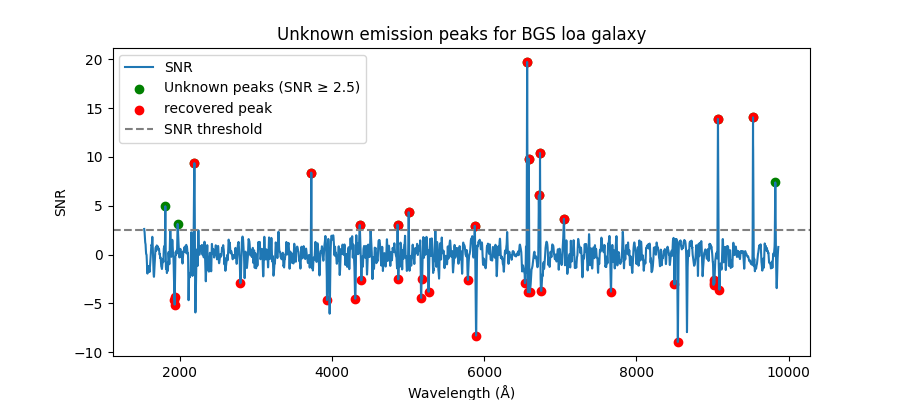

Total peaks above threshold: 14


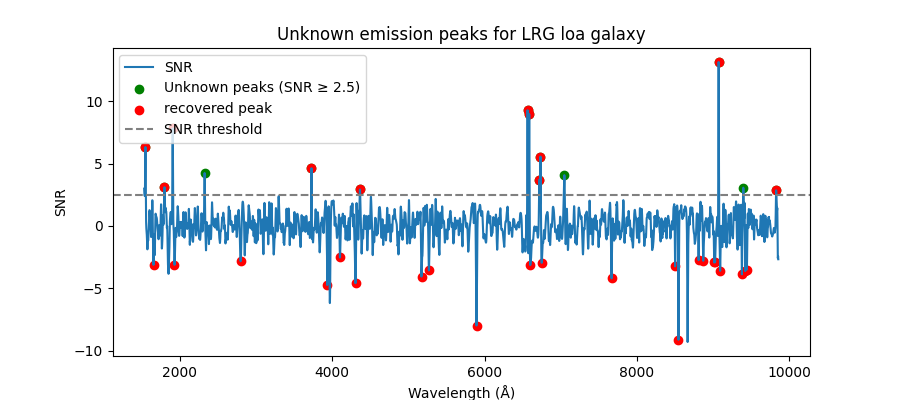

Total peaks above threshold: 17


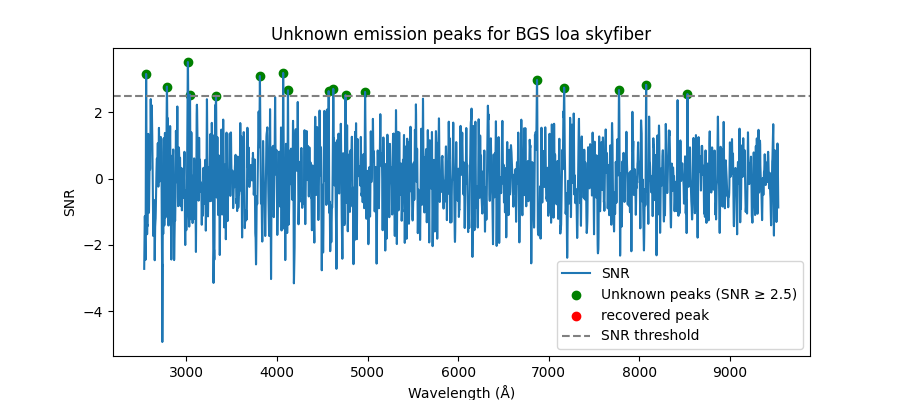

Total peaks above threshold: 16


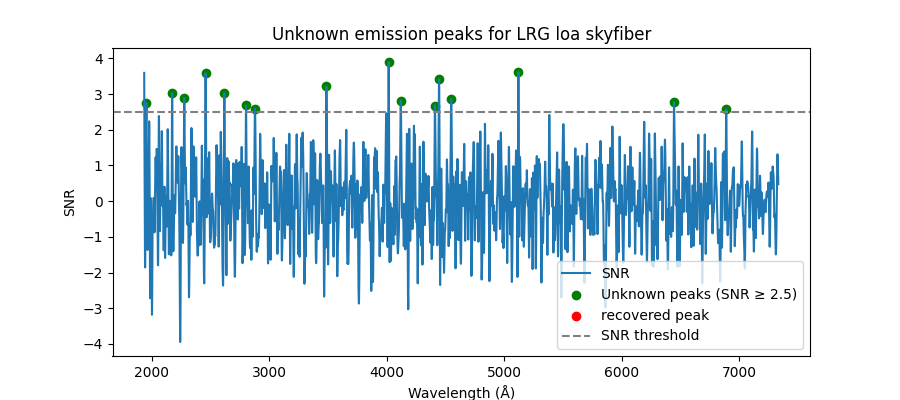

In [86]:
# green points are peaks/valeys greater than 2.5 SNR
# red points have been recovered
# all_types = ['BGS_loa_galaxy', 'LRG_loa_galaxy', 'BGS_loa_skyfiber', 'LRG_loa_skyfiber',
#                 'BGS_iron_galaxy', 'LRG_iron_galaxy', 'BGS_iron_skyfiber', 'LRG_iron_skyfiber']
all_types = ['BGS_loa_galaxy', 'LRG_loa_galaxy', 'BGS_loa_skyfiber', 'LRG_loa_skyfiber']
for type in all_types:
    entries = type.split("_")
    main(entries[0],entries[1],entries[2])